In [164]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from IPython.display import display
from collections import Counter

In [165]:
# spider trap avoidance factor
beta = 0.85
# all n connect bidirectional to each other n, and bidirectional to each p
number_n = 3
# all p connect bidirectional to each n, and directional from p to t
number_p = 1
# all f connect bidirectional to each t
number_f = 1

# DO NOT CHANGE BELOW
number_t = 1

In [166]:
# start from 1st week utils.py file

import matplotlib.pyplot as plt
import IPython
from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display
import networkx as nx
import StringIO
from networkx.drawing.nx_pydot import read_dot
from networkx.drawing.nx_pydot import from_pydot
from networkx.drawing.nx_agraph import to_agraph
import pydot

def toGraph(g):
    G = nx.Graph()
    for n in g:
        for n2 in g[n]:
            G.add_edge(n,n2)
    return G

def fromDot(s):
  P_list = pydot.graph_from_dot_data(s)
  return from_pydot(P_list[0])

def nM(d):
    '''Generate node labeler from dictionary''' 
    def m(n, N):
        if n in d:
            N.attr['label'] = n + ' ' + str(d[n])
    return m
def eM(d):
    '''Generate edge labeler from dictionary''' 
    def m(e, E):
        if e in d:
            E.attr['label'] = str(d[e])
    return m

def draw(G, mapping=None, emapping=None):
    '''draw graph with node mapping and emapping''' 
    A=to_agraph(G)
    A.graph_attr['overlap']='False'
    if mapping:
        if isinstance(mapping, dict):
            mapping = nM(mapping)
        for n in A.nodes():
            mapping(n, A.get_node(n))
    if emapping:
        if isinstance(emapping, dict):
            emapping = eM(emapping)
        for e in A.edges():
            emapping(e, A.get_edge(e[0],e[1]))
    A.layout()
    output = StringIO.StringIO()
    A.draw(output, format='svg')
    return SVG(data=output.getvalue())

# end from 1st week utils.py file

In [167]:
# matrix rows and cols order: all n, then all p, then t, then all f
# example rows: n1 n2 n3 p1 p2 t f1 f2
# returns numpy matrix
def setup_matrix():
    # number of outgoing connections
    out_connections_n = number_n + number_p - 1
    out_connections_p = number_n + number_p
    out_connections_t = number_f
    out_connections_f = number_t

    # first node of type at index
    first_n = 0
    first_p = first_n + number_n
    first_t = first_p + number_p
    first_f = first_t + number_t
    total_size = first_f + number_f

    # ranges
    range_n = range(first_p)
    range_p = range(first_p, first_t)
    range_t = range(first_t, first_f)
    range_f = range(first_f, total_size)

    # probability of randomly taking each outgoing connection
    p_n = float(1)/out_connections_n
    p_p = float(1)/out_connections_p
    p_t = float(1)/out_connections_t
    p_f = float(1)/out_connections_f

    # make a numpy matrix of total_size by total_size
    matrix = np.zeros((total_size, total_size))
    # matrix = np.matrix(matrix)

    for x in range(total_size):
        if x in range_n:
            # all n go to all n
            for y in range_n:
                if x != y:
                    matrix.put((y*total_size + x), p_n)
            # all n go to all p
            for y in range_p:
                matrix.put((y*total_size + x), p_n)

        elif x in range_p:
            # all p go to all p
            for y in range_p:
                if x != y:
                    matrix.put((y*total_size + x), p_p)
            # all p go to all n
            for y in range_n:
                matrix.put((y*total_size + x), p_p)

        elif x in range_t:
            # all t go to f
            for y in range_f:
                matrix.put((y*total_size + x), p_t)

        elif x in range_f:
            # all f to to all t
            for y in range_t:
                matrix.put((y*total_size + x), p_f)

    return matrix

# generates a matrix from a graph 
# matrix can be a float matrix for PageRank, or a 0,1 matrix for HITS when hts=true
# returns a matrix, together with a dictionary which maps each axis index onto a node
def setup_matrix_with_graph(graph, hts=False):
    axis_len = len(graph.nodes())
    matrix = np.zeros((axis_len, axis_len))
    # matrix = np.matrix(matrix)

    nodes_dict = {}
    inverted_dict = {}
    number = 0
    # first assign each node a number 
    for node in sorted(graph.nodes()):
        nodes_dict[node] = number
        inverted_dict[number] = node
        number += 1
    # then setup matrix with those numbers as x or y
    for x_node in graph.nodes():
        x_number = nodes_dict[x_node]
        number_neighbours = len(graph[x_node])
        if number_neighbours == 0:
            if not hts:
                # make circular to avoid spider traps
                matrix.put((x_number*axis_len + x_number), 1)
        else:
            out_probability = float(1)/number_neighbours
            for y_node in graph[x_node]:
                y_number = nodes_dict[y_node]
                if hts:
                    matrix.put((y_number*axis_len + x_number), 1)
                else:
                    matrix.put((y_number*axis_len + x_number), out_probability)
                    
    # PageRank matrix goes from x to y
    # HITS matrix goes from y to x
    # However, matrix is always made from x to y
    # So, if hts=true, then transpose the matrix to get the correct result matrix
    if hts:
        matrix = np.transpose(matrix)

    return matrix, nodes_dict

In [168]:
def converge_first(matrix, b):
    matrix_size = len(matrix)

    vertex = np.full((matrix_size, 1), float(1)/matrix_size)
    # vertex = np.matrix(vertex)
    
    first = np.dot(matrix, vertex)
    first = np.multiply(b, first)
    second = np.multiply(1-b, vertex)

    result = np.add(first, second)
    return result

def converge(matrix, b, vertex):
    matrix_size = len(matrix)
    one_div_n = float(1)/matrix_size
    
    first1 = np.dot(matrix, vertex)
    first2 = np.multiply(b, first1)
    second = np.multiply(1-b, one_div_n)

    result = np.add(first2, second)
    return result

def normalize(matrix):
    maximum = matrix.max()
    result = np.divide(matrix, maximum)
    return result

# get hubs and authorities from hubs and a matrix with a given hub
def converge_hits(matrix, h):
    matrix_t = np.transpose(matrix)
    
    mth = np.dot(matrix_t, h)
    a = normalize(mth)
    
    ma = np.dot(matrix, a)
    h = normalize(ma)
    return h,a

# get hubs and authorities from hubs and a matrix
def converge_hits_first(matrix):
    matrix_size = len(matrix)
    
    h = np.ones((matrix_size, 1))
    matrix_t = np.transpose(matrix)
    mth = np.dot(matrix_t, h)
    a = normalize(mth)
    
    ma = np.dot(matrix, a)
    h = normalize(ma)
    
    return h,a

In [169]:
def run_test():
    b = 1
    test_matrix = np.matrix([[0, float(1)/2, 0, 0], 
                        [float(1)/3, 0, 0, float(1)/2], 
                        [float(1)/3, 0, 1, float(1)/2], 
                        [float(1)/3, float(1)/2, 0, 0]])
    print(test_matrix)
    
    old_result = converge_first(test_matrix, b)
    result = converge(test_matrix, b, old_result)
    print("first calculation: ", result)
    
    while not np.array_equal(result, old_result):
        old_result = result
        result = converge(test_matrix, b, old_result)

    return result

def run_program(b = 1):
    matrix = setup_matrix()
    old_result = converge_first(matrix, b)
    result = converge(matrix, b, old_result)
    while not np.array_equal(result, old_result):
        old_result = result
        result = converge(matrix, 1, old_result)

    return result
        
def run_program_with_matrix(m, b=1):
    old_result = converge_first(m, b)
    result = converge(m, b, old_result)
    
    # use around to round to two decimals, as to not loop indefinitely for some graphs
    while not np.array_equal(np.around(result, 2), np.around(old_result, 2)):
        old_result = result
        result = converge(m, b, old_result)

    return result
      
def run_hits_with_matrix(m):
    h, a = converge_hits_first(m)
    old_h = None
    
    while not np.array_equal(h, old_h):
        old_h = h
        h, a = converge_hits(m, old_h)

    return h, a

def run_indegree_with_matrix(m):
    ones = np.ones((len(m), 1))
    result = np.dot(m, ones)
    return result

In [170]:
print("converged result: ", run_test())
print("should have printed approximately:", [[0]
                                            ,[0]
                                            ,[1]
                                            ,[0]])

[[0.         0.5        0.         0.        ]
 [0.33333333 0.         0.         0.5       ]
 [0.33333333 0.         1.         0.5       ]
 [0.33333333 0.5        0.         0.        ]]
('first calculation: ', matrix([[0.10416667],
        [0.14583333],
        [0.60416667],
        [0.14583333]]))
('converged result: ', matrix([[0.],
        [0.],
        [1.],
        [0.]]))
('should have printed approximately:', [[0], [0], [1], [0]])


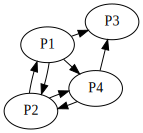

{'P2': 1, 'P3': 2, 'P1': 0, 'P4': 3}
[[0.         0.5        0.         0.        ]
 [0.33333333 0.         0.         0.5       ]
 [0.33333333 0.         1.         0.5       ]
 [0.33333333 0.5        0.         0.        ]]
[[0.00226562]
 [0.00330198]
 [0.99113043]
 [0.00330198]]


In [171]:
slides1 = fromDot('''digraph A {
    P1 -> P2;
    P1 -> P3;
    P1 -> P4;
    P2 -> P1;
    P2 -> P4;
    P4 -> P2;
    P4 -> P3;
}   
''')

display(draw(slides1))

matrix1, nodes = setup_matrix_with_graph(slides1)
print(nodes)
print(matrix1)
print(run_program_with_matrix(matrix1))

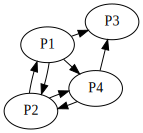

{'P2': 1, 'P3': 2, 'P1': 0, 'P4': 3}
[[0.         0.5        0.         0.        ]
 [0.33333333 0.         0.         0.5       ]
 [0.33333333 0.         1.         0.5       ]
 [0.33333333 0.5        0.         0.        ]]
[[0.10212147]
 [0.12950079]
 [0.63887694]
 [0.12950079]]


In [172]:
slides2 = fromDot('''digraph A {
    P1 -> P2;
    P1 -> P3;
    P1 -> P4;
    P2 -> P1;
    P2 -> P4;
    P4 -> P2;
    P4 -> P3;
}   
''')

display(draw(slides2))

matrix2, nodes = setup_matrix_with_graph(slides2)
print(nodes)
print(matrix2)
print(run_program_with_matrix(matrix2, 0.8))

In [173]:
slides3 = fromDot('''digraph A {
    P1 -> P2;
    P1 -> P3;
    P1 -> P4;
    P2 -> P1;
    P2 -> P4;
    P3 -> P5;
    P4 -> P2;
    P4 -> P3;
}   
''')

matrix3, nodes = setup_matrix_with_graph(slides3, True)
print(nodes)
print(matrix3)
h3, a3 = run_hits_with_matrix(matrix3)
print("\nh: ")
print h3
print("\na: ")
print a3

{'P2': 1, 'P3': 2, 'P1': 0, 'P4': 3, 'P5': 4}
[[0. 1. 1. 1. 0.]
 [1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]

h: 
[[1.        ]
 [0.35825757]
 [0.        ]
 [0.71651514]
 [0.        ]]

a: 
[[0.20871215]
 [1.        ]
 [1.        ]
 [0.79128785]
 [0.        ]]



EXERCISE 3

NOTE: for some graphs, the calculations would run (almost?) infinitely, which is why the code stops converging if the
output is the same up to and including the second decimal.
Because of this, there might be small errors in the results, for instance 0.9934 where 1 was expected.

In [174]:
def run_exercise3_p1():
    
    graph1 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        f1 -> t1;
    }
    ''')
    
    graph2 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    }
    ''')
    
    graph3 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        t1 -> f3;
        f1 -> t1;
        f2 -> t1;
        f3 -> t1;
    }
    ''')
    
    graph4 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        t1 -> f3;
        t1 -> f4;
        f1 -> t1;
        f2 -> t1;
        f3 -> t1;
        f4 -> t1;
    }
    ''')
    
    graph5 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        t1 -> f3;
        t1 -> f4;
        t1 -> f5;
        t1 -> f6;
        f1 -> t1;
        f2 -> t1;
        f3 -> t1;
        f4 -> t1;
        f5 -> t1;
        f6 -> t1;
    }
    ''')
    
    graph6 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        t1 -> f3;
        t1 -> f4;
        t1 -> f5;
        t1 -> f6;
        t1 -> f7;
        t1 -> f8;
        t1 -> f9;
        f1 -> t1;
        f2 -> t1;
        f3 -> t1;
        f4 -> t1;
        f5 -> t1;
        f6 -> t1;
        f7 -> t1;
        f8 -> t1;
        f9 -> t1;
    }
    ''')
    
    
    graphs = [graph1, graph2, graph3, graph4, graph5, graph6]
    
    array_f = []
    array_t = []
    
    for graph in graphs:
        # display(draw(graph))
        graph_matrix, graph_nodes = setup_matrix_with_graph(graph)
        result = run_program_with_matrix(graph_matrix, beta)
        # print(graph_nodes)
        # print(result)
        
        f_count = 0
        for name in graph_nodes.keys():
            if 'f' in name:
                f_count += 1
            elif name == "t1":
                index = graph_nodes[name]
                array_t.append(result[index, 0])
        array_f.append(f_count)
    
    # print(array_t)
    # print(array_f)
    plt.plot(array_f, array_t, 'o')
    plt.xlabel("PageRank of T")
    plt.ylabel("number of supporting pages f")
    plt.show()

In [175]:
def run_exercise3_p2():
    
    graph1 = fromDot('''digraph A {
        n1 -> p1;
        p1 -> n1;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    }
    ''')
    
    graph2 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> p1;
        n2 -> n1;
        n2 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    }
    ''')
    
    graph3 = fromDot('''digraph A {
        n1 -> n2;
        n1 -> n3;
        n1 -> p1;
        n2 -> n1;
        n2 -> n3;
        n2 -> p1;
        n3 -> n1;
        n3 -> n2;
        n3 -> p1;
        p1 -> n1;
        p1 -> n2;
        p1 -> n3;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    }
    ''')
    
    graph4 = fromDot('''digraph A {
        n1 -> n2;
        n2 -> n3;
        n3 -> n1;
        n3 -> n2;
        n3 -> p1;
        p1 -> n3;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    }
    ''')
    
    graph5 = fromDot('''digraph A {
        n1 -> n2;
        n2 -> n3;
        n2 -> p1;
        n3 -> n2;
        n3 -> p1;
        p1 -> n1;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    }
    ''')
    
    graph6 = fromDot('''digraph A {
        n1 -> n2;
        n2 -> n3;
        n2 -> n4;
        n2 -> n5;
        n2 -> p1;
        n3 -> n2;
        n3 -> p1;
        n4 -> n3;
        n4 -> n1;
        n4 -> p1;
        n5 -> n1;
        n5 -> n4;
        p1 -> n1;
        p1 -> t1;
        t1 -> f1;
        t1 -> f2;
        f1 -> t1;
        f2 -> t1;
    }
    ''')
    
    graphs = [graph1, graph2, graph3, graph4, graph5, graph6]
    
    array_p = []
    array_t = []
    
    for graph in graphs:
        # display(draw(graph))
        graph_matrix, graph_nodes = setup_matrix_with_graph(graph)
        result = run_program_with_matrix(graph_matrix, beta)
        # print(graph_nodes)
        # print(result)
        
        for name in graph_nodes.keys():
            if name == "p1":
                # if "p2" not in graph_nodes.keys():
                    index = graph_nodes[name]
                    array_p.append(result[index, 0])
                    
            elif name == "t1":
                index = graph_nodes[name]
                array_t.append(result[index, 0])
    
    # print(array_t)
    # print(array_p)
    plt.plot(array_p, array_t, 'o')
    plt.xlabel("PageRank of T")
    plt.ylabel("r value")
    plt.show()

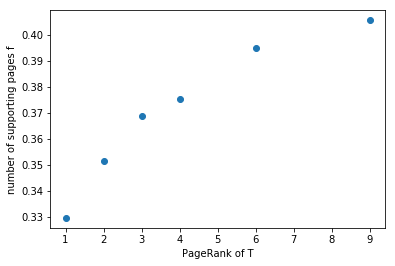

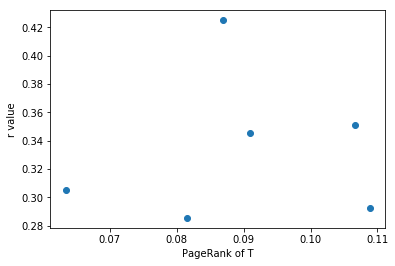

In [176]:
def run_exercise3():
    run_exercise3_p1()
    run_exercise3_p2()
    
run_exercise3()


EXERCISE 4

In [178]:

def indegree(graph):
    matrix, nodes_dict = setup_matrix_with_graph(graph, True)
    return run_indegree_with_matrix(matrix)

def pagerank(graph, b):
    matrix, nodes_dict = setup_matrix_with_graph(graph)
    return run_program_with_matrix(matrix, b)
    
def hits(graph):
    matrix, nodes_dict = setup_matrix_with_graph(graph, True)
    return run_hits_with_matrix(matrix)

graphx = fromDot('''digraph A {
        a -> b;
        a -> c;
        c -> b;
    }
    ''')
print(indegree(graphx))
print(pagerank(graphx, beta))
print(hits(graphx))

[[2.]
 [0.]
 [1.]]
[[0.05   ]
 [0.87875]
 [0.07125]]
(array([[1.        ],
       [0.        ],
       [0.61803399]]), array([[0.        ],
       [1.        ],
       [0.61803399]]))
